https://home.cc.umanitoba.ca/~krussll/phonetics/acoustic/spectrogram-sounds.html
Useful information on how to identify different vowels and consonants

A few ideas working with 2D time series data:

- Mel-Frequency Cepstrum Coefficients? Pick patterns from spectrogram.
- Hidden Markov Model
- Long-Short Term Memory Deep NN
- Dynamic Time Warping (already done in matlab code?)

Switch to manifold:
- Lose the sense of time series?

In [10]:
from scipy.io.wavfile import read
from scipy.signal import stft, hann, resample_poly
from scipy import signal
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pydub import AudioSegment
from IPython.display import Image
from csaps import csaps
import scipy.interpolate
import scipy as sp
import pandas as pd
import numpy as np
import random 
import wget
import IPython.display as ipd
import os
import sys
import warnings
Image("psd_defn.png")
warnings.filterwarnings(action='ignore') # to suppress warning messages

sys.path.append("/usr/local/lib/python3.7/site-packages/ffprobe") #I needed to do this for my computer to avoid errors
sys.path.append("/usr/local/lib/python3.7/site-packages/ffmpeg")  #when trying to use PyDub

In [23]:
#Set Path. The path will be the folder containing the .wavs.
myPath = '/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar in Diff Geo/143_midterm_project/eng_phon_wavs/'

def read_audio(word, accent='us'): #given a word, download the .mp3 from oxford and return the signal and frequency.
    url = 'https://ssl.gstatic.com/dictionary/static/sounds/oxford/{}--_{}_1.mp3'.format(word, accent)
    filename = myPath + '{}-{}'.format(word, accent)
    if not os.path.isfile(filename + '.wav'):
        wget.download(url, filename + '.mp3')
        sound = AudioSegment.from_mp3(filename + '.mp3')
        sound.export(filename + '.wav', format="wav")
    fs, x = read(filename + '.wav')
    if len(x.shape) == 2:
        x = x.sum(axis=1) / 2
    return x, fs

In [24]:
def spectrogram(x, fs): #compute and plot the spectrogram
    f, t, S = stft(x, fs, window=hann(512, sym=False), nperseg=512, noverlap=376, boundary=None)
#uncomment below to generate awesome spectrograms!
    plt.figure(figsize=(20,6))
    plt.subplot(121)
    plt.plot(x.T, c='g')
    plt.subplot(122)
    plt.imshow(abs(S), cmap='jet', origin='lower')
    plt.show()
    return f, t, S

In [ ]:
x, fs = read_audio('potato')
f, t, S = spectrogram(x, fs)
f.shape

# The researchers are creating smooth surfaces made of PSD values.
PSD is computed and smoothed in the researcher's code, but their code is inoperable because they sloppily forgot to include functions they wrote into their published work. 

What exactly is PSD?
Wikipedia: https://en.wikipedia.org/wiki/Spectral_density
The researchers also state:
![title](psd_def.png)

How do we compute it?\
**Welch's method**: https://scipy.github.io/devdocs/generated/scipy.signal.welch.html \
**Periodogram method**: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.periodogram.html \
**Matplotlib(?)**: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.psd.html

Librosa does not have a method for PSD. Most people use Welch's method. 

# Welch's Method

44962


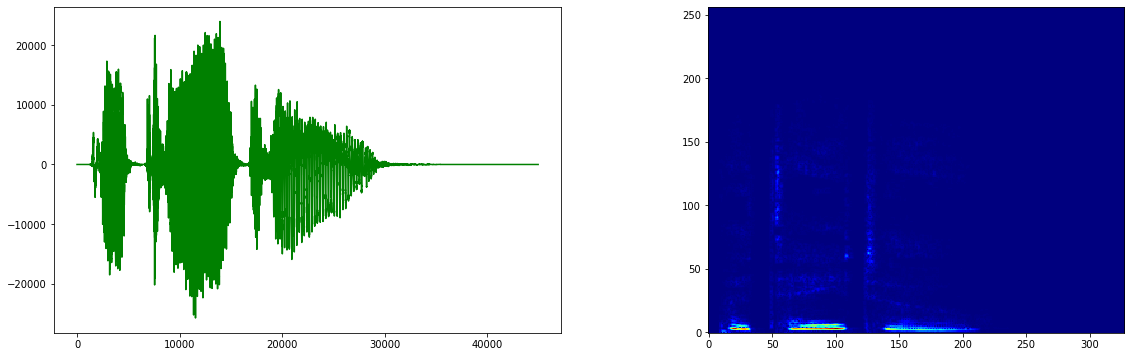

In [49]:
#Sample which we'll test on 
x, fs = read_audio('potato')
print(len(x))
f, t, S = spectrogram(x, fs)

In [73]:
f, PSD = signal.welch(x, fs)
PSD

array([1.37400459e+04, 6.46759961e+04, 4.47710391e+04, 1.66893281e+04,
       4.11775342e+03, 1.06370374e+03, 2.08999695e+02, 6.47290649e+01,
       6.08993874e+01, 5.43241463e+01, 5.38968849e+01, 6.92628326e+01,
       6.19093933e+01, 5.58132095e+01, 9.11352692e+01, 1.42070877e+02,
       1.64967361e+02, 1.66454742e+02, 1.40420151e+02, 1.47172592e+02,
       1.98982529e+02, 2.22977234e+02, 1.33928009e+02, 5.88405876e+01,
       5.31216812e+01, 3.55548820e+01, 3.56476059e+01, 8.34900894e+01,
       1.86272858e+02, 1.92887741e+02, 3.47110168e+02, 4.15089783e+02,
       3.05514832e+02, 2.16632584e+02, 1.35181335e+02, 6.21172104e+01,
       1.35332352e+02, 1.84185455e+02, 6.89539490e+01, 8.06693802e+01,
       5.53846970e+01, 4.32881203e+01, 5.52028618e+01, 6.74276810e+01,
       6.78113632e+01, 2.10049149e+02, 1.28738388e+02, 5.85209084e+01,
       1.54578690e+02, 1.13341805e+02, 6.47943954e+01, 3.33283005e+01,
       2.88988609e+01, 6.70896149e+01, 6.16746941e+01, 5.65800743e+01,
      

# Periodogram Method

In [48]:
f, PSD = signal.periodogram(x, fs)
PSD.shape

(22482,)

# MatPlotLib's plot and computation of PSD

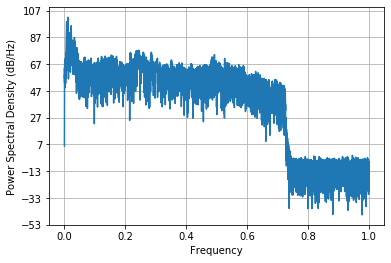

In [35]:
matplotlib_psd = plt.psd(x, fs)

In [45]:
matplotlib_psd[0].shape

(22051,)

# The researchers' attempt(?) at computing PSD

In [10]:
def logPSD(directory): #Outputs a list of PSDs. The"directory" is the path which contains the wavs of interest. 
    PSD_list = [] #initialize the list
    for filename in os.listdir(directory): #iterate through directory
        if filename.endswith(".wav"): #only picks up .wav's
            fs, x = read(directory + "/" + filename) 
            f, t, S = spectrogram(x, fs)
            norm_signal = np.square(abs(S)) #take the magnitude of cmplx numbers of S, then square each entry. I.e. replace each z with |z|^2.
            norm_signal = norm_signal/np.amax(norm_signal) #rescale the signal
            norm_signal[norm_signal < 10^(-16)] = 10^(-16) #replace all elements < 10^(-16) with 10^(-16)
            log_signal = np.log10(norm_signal) #to calculate PSD, we take the log and then multiply it by 10.
            PSD_list.append(10*log_signal) #finally, add to our list
    return PSD_list

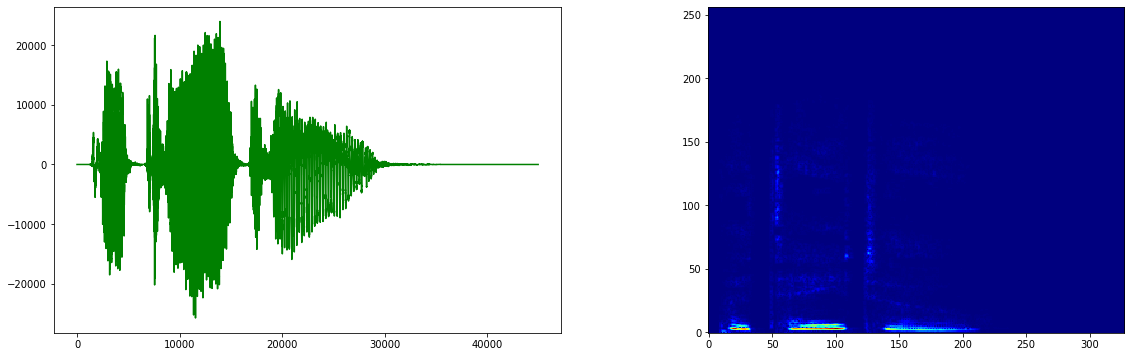

In [12]:
potato_PSD = logPSD("/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar in Diff Geo/143_midterm_project/eng_phon_wavs")
potato_PSD = potato_PSD[0]

# Smoothing Surfaces. 
Below is a cubic spline smoothing algorirthm for sufaces. It's fast and simple. 

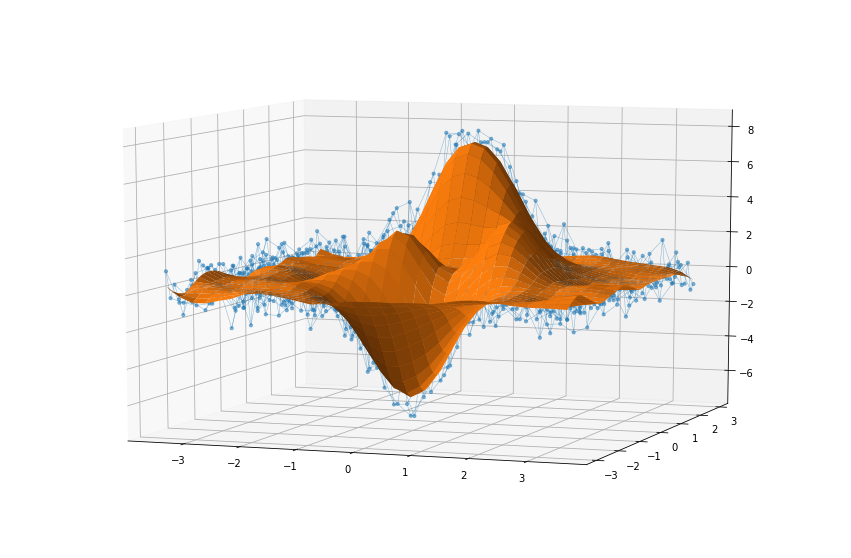

In [9]:
#Basic example
np.random.seed(1)
xdata = [np.linspace(-3, 3, 41), np.linspace(-3.5, 3.5, 31)]
i, j = np.meshgrid(*xdata, indexing='ij')
ydata = (3 * (1 - j)**2. * np.exp(-(j**2) - (i + 1)**2)
         - 10 * (j / 5 - j**3 - i**5) * np.exp(-j**2 - i**2)
         - 1 / 3 * np.exp(-(j + 1)**2 - i**2))
ydata = ydata + (np.random.randn(*ydata.shape) * 0.75)

ydata_s = csaps(xdata, ydata, xdata, smooth=0.988)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('none')
c = [s['color'] for s in plt.rcParams['axes.prop_cycle']]
ax.plot_wireframe(j, i, ydata, linewidths=0.5, color=c[0], alpha=0.5)
ax.scatter(j, i, ydata, s=10, c=c[0], alpha=0.5)
ax.plot_surface(j, i, ydata_s, color=c[1], linewidth=0, alpha=1.0)
ax.view_init(elev=9., azim=290)

plt.show()

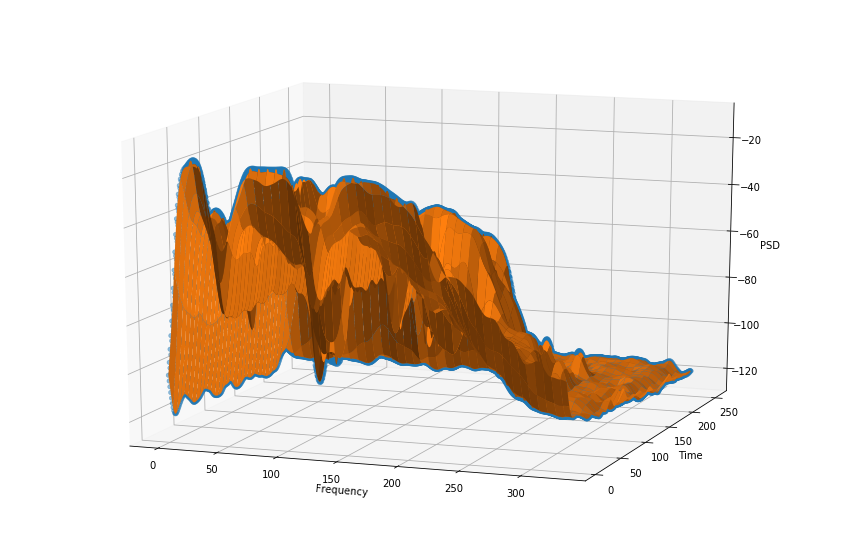

In [71]:
#Trying to smooth the PSD data generated by the researcher's methods.
xdata = [np.linspace(0, 257, 257), np.linspace(0, 328, 328)]
i,j = np.meshgrid(*xdata, indexing = "ij")
z_data = potato_PSD.flatten("F")

smooth = [
    0.95,  # the smoothing parameter for X
    0.83,  # the smoothing parameter for Y
    0.51,  # the smoothing parameter for Z
]

zdata_s = csaps(xdata, potato_PSD, xdata, smooth=0.998)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('none')
c = [s['color'] for s in plt.rcParams['axes.prop_cycle']]
ax.scatter(j, i, zdata_s, linewidths=0.5, color=c[0], alpha=0.5)
ax.plot_surface(j, i, zdata_s, color=c[1], linewidth=0, alpha=1)
ax.view_init(elev=15., azim=290)
ax.set_xlabel('Frequency')
ax.set_ylabel('Time')
ax.set_zlabel('PSD');

# Stategy 2: Call Matlab in python to compute PSD...
It's clear that the researcher's code is doing something to the PSDs, something which we can't understand because their code is so badly written. But we can still use their matlab code, to get the smooth surface data, and then smooth the data in python. So we can completely do away with the R part of their code. 

In [58]:
#to do this, we need to talk to bash to run Matlab. We can use subprocess to talk to bash.
#Here I'll test this out on "potato."

import subprocess
from subprocess import Popen, PIPE

myBashCommands = ["cd /Applications/MATLAB_R2018b.app/bin;"]    

myBashCommands[0] += "./matlab -nodesktop -r "
myBashCommands[0] += "'cd(\"/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_midterm_project/3d_spectrogram_surfaces\"); "
myBashCommands[0] += "potato_wav = audioread(\"potato-us.wav\"); "
myBashCommands[0] += "[f, t,  psd] = GetSpectrogram(potato_wav, 16000, 10); "
myBashCommands[0] += "smooth_psd = smoothn(10*log(psd), .5); " 
myBashCommands[0] += "smooth_psd = SurfaceCubicInterpolator(smooth_psd, 100); "
myBashCommands[0] += "dlmwrite(\"smooth_psd.csv\", smooth_psd, char(\"precision\"), 10);"
myBashCommands[0] += "quit()'"

subprocess.run(myBashCommands,stderr=PIPE, stdout=PIPE, shell = True, check = True)


CompletedProcess(args=['cd /Applications/MATLAB_R2018b.app/bin;./matlab -nodesktop -r \'cd("/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_midterm_project/3d_spectrogram_surfaces"); potato_wav = audioread("potato-us.wav"); [f, t,  psd] = GetSpectrogram(potato_wav, 16000, 10); smooth_psd = smoothn(10*log(psd), .5); smooth_psd = SurfaceCubicInterpolator(smooth_psd, 100); dlmwrite("smooth_psd.csv", smooth_psd, char("precision"), 10);quit()\''], returncode=0, stdout=b'\n                            < M A T L A B (R) >\n                  Copyright 1984-2018 The MathWorks, Inc.\n              R2018b Update 7 (9.5.0.1298439) 64-bit (maci64)\n                              January 22, 2020\n\n \nTo get started, type doc.\nFor product information, visit www.mathworks.com.\n \n', stderr=b'{\x08Error using audioread (line 90)\nThe filename specified was not found in the MATLAB path.\n}\x08 \n')

In [63]:
def psd_smoother(word, wordWavPath, psdPath, matlabScriptsPath): #creates the smooth psd using matlab functions.
    matlabLocation = "/Applications/MATLAB_R2018b.app/bin" #the path for matlab 
    
    myBashCommands = ["cd " + matlabLocation + ";"] #go inside matlab package
    myBashCommands[0] += "./matlab -nodesktop -r " #run with no desktop
    myBashCommands[0] += "'cd(\"" + matlabScriptsPath + "\"); "  #cd to our directory containing our matlab scripts
    myBashCommands[0] += "word_wav = audioread(\""+ wordWavPath + "\"); " #read in our word
    myBashCommands[0] += "[f, t,  psd] = GetSpectrogram(word_wav, 16000, 10); " #compute spectrogram
    myBashCommands[0] += "smooth_psd = smoothn(10*log(psd), .5); " #smooth it 
    myBashCommands[0] += "smooth_psd = SurfaceCubicInterpolator(smooth_psd, 100); " #smooth it again
    myBashCommands[0] += "dlmwrite(\"" + psdPath + word + "_smooth_psd.csv\", smooth_psd, char(\"precision\"), 10);" #save psd data
    myBashCommands[0] += "quit()'" #close matlab

    subprocess.run(myBashCommands,stderr=PIPE, stdout=PIPE, shell = True, check = True) #run all of our above bash commands


In [82]:
import os
from numpy import genfromtxt
myPath = '/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_midterm_project/3d_spectrogram_surfaces/' #Path containing this notebook; change this

def word_to_surface(word, myPath, accent='us'): #given a word, download the .mp3 from oxford and return the signal and frequency.
    myPath = '/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_midterm_project/3d_spectrogram_surfaces/'
    
    ## Setting paths for later; keeps things organized.
    wavPath = myPath + "wavs/"                      #full path for the the .wav files
    psdPath = myPath + "psd_data/"                  #full path for the psd data 
    matlabScriptsPath = myPath + "matlab_scripts/"  #full path to get to the matlab scripts
    
    ## Now we get the words from the web and compute the psd
    url = 'https://ssl.gstatic.com/dictionary/static/sounds/oxford/{}--_{}_1.mp3'.format(word, accent) #warning: the oxford website could change their website formats for .mp3s in the future; may be a bug source in the future
    wavFileName = wavPath + '{}-{}'.format(word, accent)
    
    print(wavFileName)
    if not os.path.isfile(wavFileName + '.wav'):            #if we haven't made the .wav before, then make it
        wget.download(url, wavFileName + '.mp3')            #download the .mp3
        sound = AudioSegment.from_mp3(wavFileName + '.mp3') 
        sound.export(wavFileName + '.wav', format="wav")    #the .wav is now created. 
    
    psdCSV = psdPath + word + "_smooth_psd.csv" #our psd data
    if not os.path.isfile(psdCSV):              #if we haven't made the .csv before, then make it
        wordWavPath = wavFileName + ".wav"
        psd_smoother(word, wordWavPath, psdPath, matlabScriptsPath,) #call helper function to compute psd
    
    word_psd = genfromtxt(psdCSV, delimiter=',')
    
    print(word_psd.shape)
    ## finally, we plot the surface
    xdata = [np.linspace(0, 81, 81), np.linspace(0, 100, 100)] #our x-y coordinates
    i,j = np.meshgrid(*xdata, indexing = "ij")              #creates the 81x100 grid
#     zdata_s = word_psd
    zdata_s = csaps(xdata, word_psd, xdata, smooth=0.9)   #using csaps to smooth our surface
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_facecolor('none')
    c = [s['color'] for s in plt.rcParams['axes.prop_cycle']]
    ax.scatter(j, i, zdata_s, linewidths=0.5, color=c[0], alpha=0.5)
    ax.plot_surface(j, i, zdata_s, color=c[1], linewidth=0, alpha=1)
    ax.view_init(elev=20, azim=20)
    plt.show()

/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_midterm_project/3d_spectrogram_surfaces/wavs/stop-us
(81, 100)


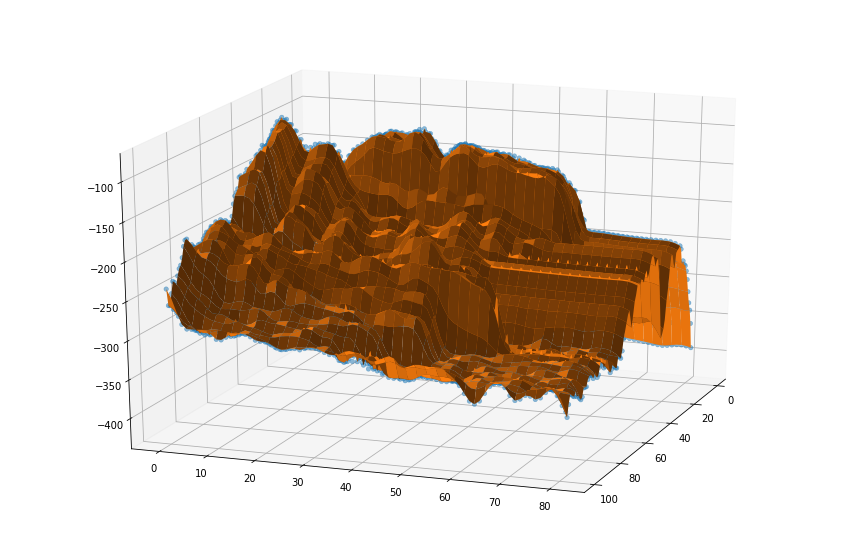

In [83]:
word_to_surface("stop", myPath)